In [45]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

In [46]:
from sklearn import preprocessing

In [72]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN

from sklearn.linear_model import LogisticRegression

In [48]:
from sklearn.metrics.cluster import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics.cluster import rand_score

from sklearn.metrics import accuracy_score

In [49]:
from scipy.spatial import ConvexHull
from scipy.cluster.hierarchy import dendrogram, linkage
from clustergram import Clustergram
from mpl_toolkits.mplot3d import Axes3D
import plotly
import plotly.express as px
from sklearn.manifold import TSNE

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
df = pd.read_csv('data/segmented_customers.csv')
df.head()

,customer_id,gender,age,annual_income,spending_score
0,1,1,19.0,15.0,39.0
1,2,1,21.0,15.0,81.0
2,3,0,20.0,16.0,6.0
3,4,0,23.0,16.0,77.0
4,5,0,31.0,17.0,40.0


In [52]:
# посмотрим, есть ли пропуски в датасете
df.isna().sum()

customer_id       0
gender            0
age               0
annual_income     0
spending_score    0
dtype: int64

In [53]:
# переименуем столбцы для более удобной работы
df.rename(columns={'CustomerID' : 'customer_id', 
                   'Gender' : 'gender',
                   'Age' : 'age',
                   'Annual income (k$)' : 'annual_income',
                   'Spending score (1-100)' : 'spending_score'
                   }, 
          inplace=True)

In [54]:
# проверим, есть ли в данных дубликаты
df[df.duplicated(subset=['customer_id'])]

,customer_id,gender,age,annual_income,spending_score


In [55]:
# передаём датафрейм и поля, которые нужно использовать для осей абсцисс, ординат и аппликат
fig = px.scatter_3d(
    data_frame=df,
    x = 'age',
    y = 'annual_income',
    z = 'spending_score',
    width=1000,
    height=700
)

fig.show()

In [56]:
def get_3d_visualization(df, clust_res):
    fig = px.scatter_3d(
        data_frame=df,
        x = 'age',
        y = 'annual_income',
        z = 'spending_score',
        color = clust_res,
        width=1000,
        height=700
    )
    
    return fig

In [57]:
# признаки, по которым будем проводить моделирование
X = df[['age', 'annual_income', 'spending_score']]

In [58]:
# DBSCAN-кластеризация со значениями по умолчанию
dbs_res = DBSCAN().fit_predict(X)

get_3d_visualization(X, dbs_res)

In [59]:
# DBSCAN-кластеризация с подбором радиуса вокруг точки (eps)
dbs_res = DBSCAN(eps=11).fit_predict(X)

get_3d_visualization(df, dbs_res)

In [60]:
# функция, которая будет проводить алгомеративную кластеризацию
# на вход она будет принимать X — матрицу с признаками для кластеризации и n_clusters — количество кластеров,
# на выходе будет возвращать список с номерами кластеров
def get_agg_cl(X, n_clusters):
    # запустим агломеративную кластеризацию
    agg = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    # обучим модель агломеративной кластеризации, получим список с предсказаниями кластеров
    agg_res = agg.fit_predict(X)
    
    return agg_res

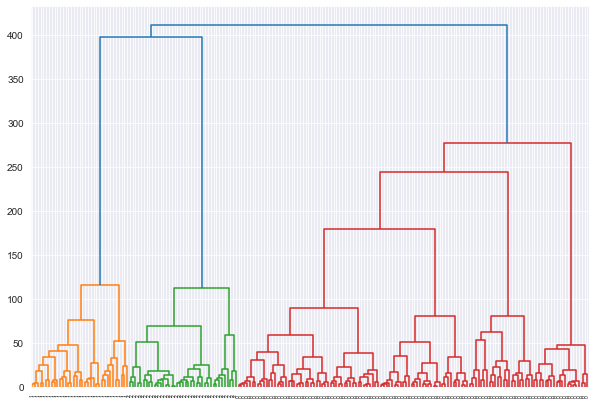

In [61]:
# агломеративная кластеризация
agg_res = get_agg_cl(X, 3)

# визуализация полученной дендрограммы
linked = linkage(X, 'ward')

plt.figure(figsize=(10, 7))

dendrogram(
    Z=linked,
    orientation='top',
    labels=agg_res,
    distance_sort='descending'
)

plt.show()

In [62]:
# агломеративная кластеризация
agg_res = get_agg_cl(X, 6)

# визуализация
get_3d_visualization(X, agg_res)

In [63]:
# напишем функцию для подсчёта коэффициента силуэта
def get_silhouette_agg_clust(X, cluster_num):
    # проведём агломеративную кластеризацию с заданным количеством кластеров
    res = get_agg_cl(X, cluster_num)
    # рассчитаем коэффициент силуэта
    silhouette = silhouette_score(X, res)
    return silhouette

In [64]:
# создадим пустой словарь, ключами будут коэффициент силуэта и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}


for cluster_num in range(2, 10):
    silhouette_res["silhouette"].append(get_silhouette_agg_clust(X, cluster_num))
    silhouette_res["cluster"].append(cluster_num)

# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

<AxesSubplot: xlabel='cluster', ylabel='silhouette'>

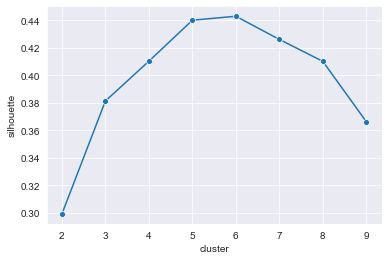

In [67]:
# установим стиль для визуализиции
sns.set_style("darkgrid")
# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker="o")

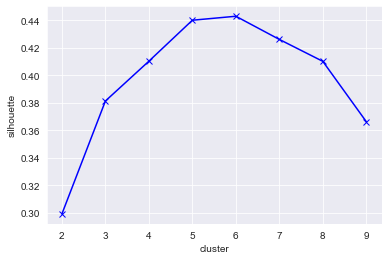

In [69]:
silhouette = []

for cl_num in range(2, 10):
    silhouette.append(get_silhouette_agg_clust(X, cl_num))
    
plt.xlabel('cluster')
plt.ylabel('silhouette')
plt.plot([i for i in range(2, 10)], silhouette, 'xb-')

In [70]:
df['cluster'] = agg_res
df.head()

,customer_id,gender,age,annual_income,spending_score,cluster
0,1,1,19.0,15.0,39.0,4
1,2,1,21.0,15.0,81.0,3
2,3,0,20.0,16.0,6.0,4
3,4,0,23.0,16.0,77.0,3
4,5,0,31.0,17.0,40.0,4


In [71]:
data = pd.read_csv('data/cl.csv')
data.head()

,customer_id,gender,age,annual_income,spending_score,cluster
0,1,1,19.0,15.0,39.0,3
1,2,1,21.0,15.0,81.0,4
2,3,0,20.0,16.0,6.0,3
3,4,0,23.0,16.0,77.0,4
4,5,0,31.0,17.0,40.0,3


In [73]:
completeness_score(labels_true=data.cluster, labels_pred=df.cluster)

0.9858363091910892